Step 2 notebooks are revolved around creating and assessing the latent space.

Steps performed in this notebook:

**1. Load in embeddings:** Load in the embeddings created in notebook 1.

**2. Linear Canonical Correlation Analysis:** The spectral and molecular embeddings are combined into one embedding by utilising **Canonical Correlation Analysis**. CCA maximizes correlation between two given data views by reducing the dimensions and morphing the data in a way so that the two data views are similar to each other. Here, the spectral embeddings are considered the X and the structural embeddings the Y. Every X (spectrum) has a corresponding Y (structure).

**3. Deep Canonical Correlation Analysis:** DCCA utilizes a neural network to maximize the correlation between X and Y. It has the added benefits of learnable parameters and non-linear transformations.

In [1]:
# Set plot style
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
%matplotlib inline

## 1. Load in embeddings

In [2]:
import os 
import pickle 
import pandas as pd
import seaborn as sns

data_path = '/lustre/BIF/nobackup/unen004/data'
with open(os.path.join(data_path, 'full_dataframe_normalized.pickle'), 'rb') as f:
    df = pickle.load(f)
df.head()

,spectrum_id,compound_name,smiles,inchikey,inchikey14,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class_results,npc_superclass_results,npc_pathway_results,npc_isglycoside,mol,sentence,ms2ds,spec2vec,mol2vec
0,CCMSLIB00000001547,3-Des-Microcystein_LR,CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=...,IYDKWWDUBYWQGF-NNAZGLEUSA-N,IYDKWWDUBYWQGF,Organic compounds,Organic acids and derivatives,Peptidomimetics,Hybrid peptides,Hybrid peptides,Cyclic peptides; Microcystins,Oligopeptides,Amino acids and Peptides,0,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3537119515, 2245273601, 242354360...","[0.0, 0.11211989062426796, 0.0, 0.158931198460...","[0.03837159812841756, 0.09913249716376928, 0.0...","[0.005604683527400814, -0.02301042087378335, -..."
1,CCMSLIB00000001548,Hoiamide B,CCC[C@@H](C)[C@@H]([C@H](C)[C@@H]1[C@H]([C@H](...,KNGPFNUOXXLKCN-ZNCJFREWSA-N,KNGPFNUOXXLKCN,Organic compounds,Organic acids and derivatives,Peptidomimetics,Depsipeptides,Cyclic depsipeptides,Cyclic peptides,Oligopeptides,Amino acids and Peptides,0,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3542456614, 2245384272, 117312591...","[0.0, 0.10557166694366461, 0.0, 0.188627002322...","[0.07626190933359983, 0.1290448493814702, 0.06...","[-0.009834483545748103, -0.027489677816243393,..."
2,CCMSLIB00000001550,Scytonemin,OC1=CC=C(\C=C2\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\C...,CGZKSPLDUIRCIO-RPCRKUJJSA-N,CGZKSPLDUIRCIO,Organic compounds,Organoheterocyclic compounds,Indoles and derivatives,NaN,Indoles and derivatives,NaN,NaN,Shikimates and Phenylpropanoids,0,"<img data-content=""rdkit/molecule"" src=""data:i...","(864662311, 26234434, 3217380708, 2905660137, ...","[0.0, 0.1336975940932368, 0.0, 0.1912738648554...","[0.0792954864406949, 0.0829470276451531, -0.03...","[0.022136275297993648, -0.003164903719515904, ..."
3,CCMSLIB00000001552,Hectochlorin,C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([...,USXIYWCPCGVOKF-LERJCCFDSA-N,USXIYWCPCGVOKF,Organic compounds,Organic acids and derivatives,Peptidomimetics,Depsipeptides,Cyclic depsipeptides,Cyclic peptides; Depsipeptides,Oligopeptides,Amino acids and Peptides; Polyketides,0,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1858577693, 2976033787, 267264863...","[0.0, 0.0, 0.0, 0.20587242288185872, 0.2475291...","[0.005036696565324857, -0.057816207361243564, ...","[-0.0010993798911880348, -0.031671053774092295..."
4,CCMSLIB00000001554,Cyclomarin A,C[C@H]1C(=O)N[C@H](C(=O)N[C@H](C(=O)N([C@H](C(...,WCNJVJCYRBJSLC-BCJYPDSRSA-N,WCNJVJCYRBJSLC,Organic compounds,Phenylpropanoids and polyketides,Macrolactams,NaN,Macrolactams,Cyclic peptides,Oligopeptides,Amino acids and Peptides,0,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 1858577693, 2976033787, 125971071...","[0.06848110642982089, 0.0, 0.08852951477401143...","[-0.0067413807360351555, 0.03144355490931601, ...","[-0.0012273630584583826, -0.03138404125269303,..."


### 1.1 Filter on cf_class
Only classes that belong to 2 or more spectra are kept, which is required for stratify in train_test_split() later.

In [3]:
# Filter out spectra that are part of cf_class that exists less than twice in whole df
v = df.cf_class.value_counts()
df = df[df.cf_class.isin(v.index[v.gt(1)])] 
df = df.set_index('spectrum_id')
print("Final num spectra: %s" % len(df))

Final num spectra: 15145


[Text(0, 0, '1836'),
 Text(0, 0, '1583'),
 Text(0, 0, '1355'),
 Text(0, 0, '910'),
 Text(0, 0, '780'),
 Text(0, 0, '751'),
 Text(0, 0, '566'),
 Text(0, 0, '489'),
 Text(0, 0, '471'),
 Text(0, 0, '376'),
 Text(0, 0, '6028')]

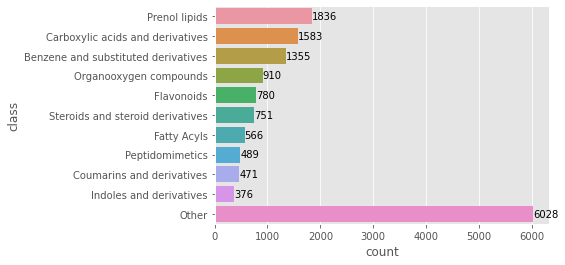

In [4]:
# Make plot for classes
df_class = pd.DataFrame(df['cf_class'].value_counts().nlargest(10)).reset_index()
df_class.columns = ['class', 'count']
misc_count = len(df) - df_class['count'].sum()
df_class = df_class.append({'class': 'Other', 'count':misc_count}, ignore_index=True)

g = sns.barplot(data=df_class, x='count', y='class')
g.bar_label(g.containers[0])

In [5]:
# Unique classes in data
df['cf_class'].nunique()

228

In [6]:
from sklearn.model_selection import train_test_split

# Split df into train and test
df_train, df_test = train_test_split(df, test_size = 0.2,     # 20% test size
                                    random_state = 1,         # for reproducibility
                                    stratify=df['cf_class']   # distribute classes evenly
                                    )
df_train['set'] = 'train'
df_test['set'] = 'test'
df_train = df_train.sort_index()
df_test = df_test.sort_index()
print(len(df_train), len(df_test))

12116 3029


------------------------------------------
## 2. Linear Canonical Correlation Analysis (CCA)
Linear CCA is performed with cca_zoo's CCA module. The amount of dimensions can be any number. Here it is set at 100, which was decided with notebook 3.3-compare_tanimoto_distributions.

In [7]:
# CCA settings
latent_dims = 100

First, the CCA model is initiated using the chosen amount of latent dimensions. The CCA model is then trained using the train Spec2Vec embeddings as the X, and the train Mol2Vec embeddings as the Y. This calculates canonical weights that are needed to transform the data into canonical variates where the correlation is maximized. Then, both the train and test data are transformed by applying the model to the original variables. Additionally, the correlations between X and Y for every canonical dimension/component are calculated.

In [8]:
import numpy as np
import pandas as pd
#from sklearn.cross_decomposition import CCA
from cca_zoo.models import CCA

from datetime import datetime

def perform_cca(df_train, df_test, colX, colY, latent_dims=10):
    """Use sklearn's CCA to make CCA model, train it, and transform the embeddings.
    """     
    # Format the embeddings as vectors
    trainX = np.array([x for x in df_train[colX]]) # x
    trainY = np.array([x for x in df_train[colY]]) # y
    
    testX = np.array([x for x in df_test[colX]]) # x
    testY = np.array([x for x in df_test[colY]]) # y

    # Init model
    cca = CCA(latent_dims=latent_dims)
    
    # Fit model to data, aka train model
    then = datetime.now()
    cca.fit((trainX, trainY))
    print("Time taken to train:", datetime.now() - then)
        
    # Apply the dimension reduction, aka apply canonical weights to get canonical variables
    trainX_latent, trainY_latent = cca.transform((trainX, trainY))
    testX_latent, testY_latent = cca.transform((testX, testY))
    
    # Add latent space to dataframes
    df_train['X'] = [x for x in trainX_latent] 
    df_train['Y'] = [y for y in trainY_latent]
    df_test['X'] = [x for x in testX_latent]
    df_test['Y'] = [y for y in testY_latent]
    df = pd.concat([df_train, df_test]).sort_index()
    
    # Calc canonical components -- .score() also works for cca_zoo
    train_comps = [np.corrcoef(trainX_latent[:,i], trainY_latent[:,i])[1,0] for i in range(latent_dims)]
    test_comps = [np.corrcoef(testX_latent[:,i], testY_latent[:,i])[1,0] for i in range(latent_dims)]
    comps = pd.DataFrame([train_comps, test_comps], index=['train','test'], columns=np.arange(latent_dims)+1)
    
    return df, comps

In [9]:
df_spec2vec, comps_df_spec2vec = perform_cca(df_train, df_test, 'spec2vec', 'mol2vec', latent_dims)

Time taken to train: 0:00:01.315613


In [10]:
df_ms2ds, comps_df_ms2ds = perform_cca(df_train, df_test, 'ms2ds', 'mol2vec', latent_dims)

Time taken to train: 0:00:00.791042


### 2.1 Plots
The correlations for each canonical correlation is plotted for both train and test.

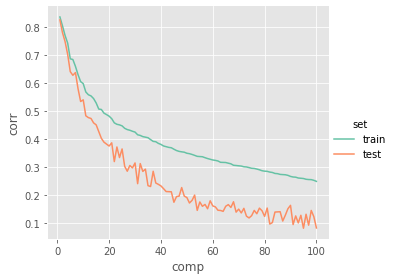

In [11]:
import seaborn as sns

def plot_canonical_comps(comps_df, latent_dims):
    """'comps' stands for the cca 'components'
    """
    # Prepare dataframe for plotting
    comps_df['set'] = comps_df.index  # set new column equal to the indices - train, test
    comps_df_m = comps_df.melt(id_vars=['set'], 
                               var_name='comp', value_name='corr')
    
    g = sns.FacetGrid(comps_df_m, hue='set',height=4, aspect=1.2, palette='Set2')#['slateblue','lightsalmon','tomato']
    g.map(sns.lineplot, 'comp', 'corr')
    #g.set(xticks=np.arange(0,latent_dims+1,10)) # show ticks each x increments
    g.add_legend()
    
plot_canonical_comps(comps_df_spec2vec, latent_dims)

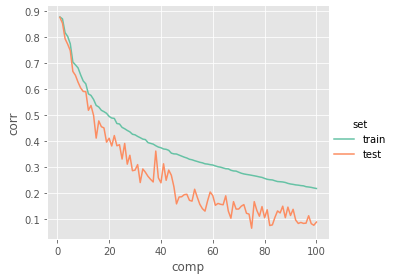

In [12]:
plot_canonical_comps(comps_df_ms2ds, latent_dims)

The first two dimensions of the combined embedding latent space are plotted. The first plot contains dimension 1 and dimension 2 respectively, with Spec2Vec on the x-axis and Mol2Vec on the y-axis. 


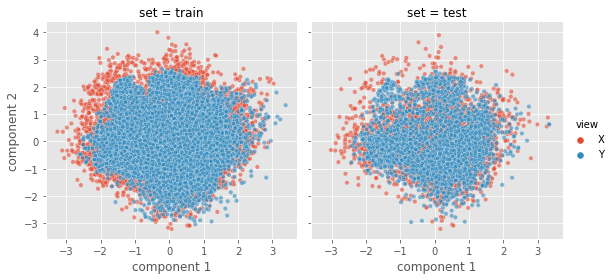

In [13]:
def plot_2d_latent(df):    
    # Seperate X and Y columns into rows
    df_m = df.melt(value_vars=['X', 'Y'], id_vars=['set'], var_name='view', 
                   value_name='latent', ignore_index=False)

    # Transform the latent dimensions into their own columns
    df_latent = pd.DataFrame(df_m['latent'].apply(pd.Series))
    df_latent.columns = ["component %s" % (i+1) for i in df_latent.columns]
    df_m = pd.concat([df_m, df_latent], axis=1)
    df_m = df_m.drop(columns=['latent'])

    # Plot the first two dimensions per spectral type
    sns.relplot(data=df_m, x='component 1', y='component 2', col="set", hue="view", 
                alpha=0.6, s=20, height=4, aspect=1)#, palette=['slateblue','lightsalmon']) #ms2ds = cornflowerblue or smth

plot_2d_latent(df_spec2vec)

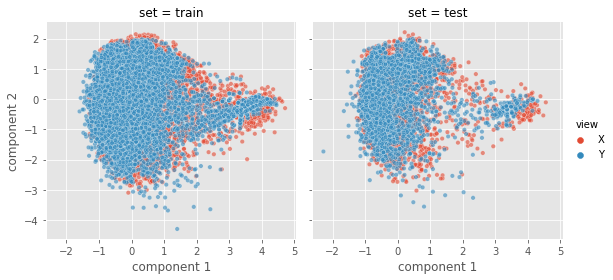

In [14]:
plot_2d_latent(df_ms2ds)

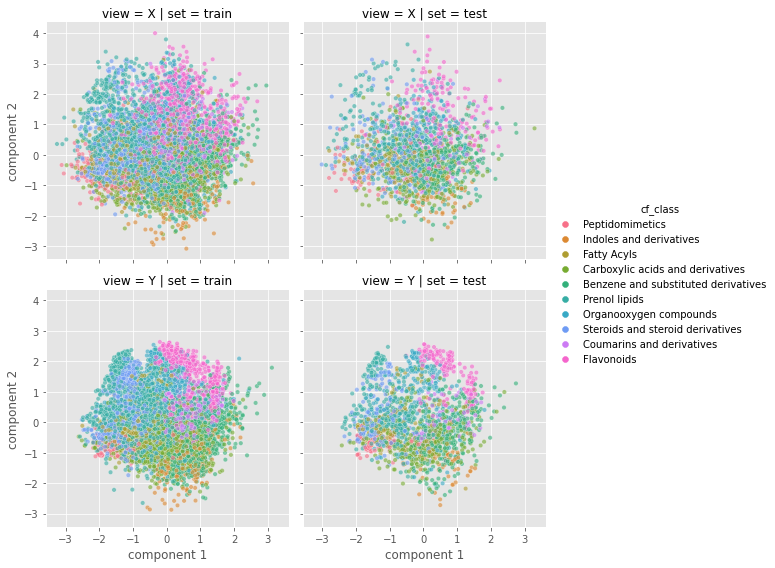

In [29]:
def filter_on_top_n_classes(this_df, num_classes=10):
    """Only keep the top n most abundant classes."""
    top_classes = this_df.cf_class.value_counts().nlargest(num_classes).index.tolist()
    this_df = this_df[this_df.cf_class.isin(top_classes)]
    this_df = this_df.reset_index(drop=True)
    return this_df

def plot_latent_classes(df):    
    # Filter top 10 classes for visualisation 
    df = filter_on_top_n_classes(df)

    # Seperate X and Y columns into rows
    df_m = df.melt(value_vars=['X', 'Y'], id_vars=['set', 'cf_class'], var_name='view', 
                   value_name='latent', ignore_index=False)

    # Transform the latent dimensions into their own columns
    df_latent = pd.DataFrame(df_m['latent'].apply(pd.Series))
    df_latent.columns = ["component %s" % (i+1) for i in df_latent.columns]
    df_m = pd.concat([df_m, df_latent], axis=1)
    df_m = df_m.drop(columns=['latent'])

    # Plot the first two dimensions per spectral type
    sns.relplot(data=df_m, x='component 1', y='component 2', col="set", row='view', hue="cf_class", 
                alpha=0.6, s=20, height=4, aspect=1)#, palette=['slateblue','lightsalmon']) #ms2ds = cornflowerblue or smth
    
plot_latent_classes(df_spec2vec)

### 2.2 Save to files

In [16]:
# Save to file
def save_pickle(df, fn, path):
    with open(os.path.join(path, '%s.pickle' % fn), 'wb') as f:
        pickle.dump(df, f) 

save_pickle(df_spec2vec, 'dataframe_spec2vec_cca_%s' % latent_dims, data_path)
save_pickle(df_ms2ds, 'dataframe_ms2ds_cca_%s' % latent_dims, data_path)

------------------------------------------
## 3. Deep Canonical Correlation Analysis (DCCA)
CCA_ZOO has more CCA methods than just linear CCA. One of such is Deep CCA, which utilizes a neural network. First, 10% of the train set is taken out to be used as a validation set during training. Then the datasets are turned into CCA_Datasets, and data loaders are setup. Then encoders are setup and used to initialize the model. The model is trained using a chosen number of epochs. And then the data is transformed using the learned model. 

PS. Sometimes the network gives an error after a couple epochs, but just trying again has always worked for me.

In [17]:
import pytorch_lightning as pl
from cca_zoo.deepmodels import DCCA, CCALightning, get_dataloaders, architectures
from cca_zoo.data import CCA_Dataset

def perform_dcca(df_train, df_test, colX, colY, latent_dims=10, epochs=20, layers=[128]):
    """Use cca_zoo's DCCA to make Deep CCA model, train it, and transform the embeddings.
    """     
    
    # Create a validation set from small part of the train data
    df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=1, stratify=df_train['cf_class']) 
    df_val['set'] = 'val'

    # Format the embeddings as vectors
    trainX = np.array([x for x in df_train[colX]]) # x
    trainY = np.array([x for x in df_train[colY]]) # y

    valX = np.array([x for x in df_val[colX]]) # x
    valY = np.array([x for x in df_val[colY]]) # y

    testX = np.array([x for x in df_test[colX]]) # x
    testY = np.array([x for x in df_test[colY]]) # y

    # Data should be either tuple of 2d numpy arrays (one for each view) or torch dataset
    train_dataset = CCA_Dataset([trainX, trainY])
    val_dataset = CCA_Dataset([valX, valY])
    test_dataset = CCA_Dataset([testX, testY])
    
    sample_amount = len(train_dataset)
    train_loader, val_loader = get_dataloaders(train_dataset, val_dataset, batch_size=128, num_workers=6,
                                              drop_last=False) #num_workers=48, 
    test_loader = get_dataloaders(test_dataset) #  num_workers=48
    
    # Setup encoders
    encoder_1 = architectures.Encoder(latent_dims=latent_dims, feature_size=trainX.shape[1],
                                     layer_sizes=layers)
    encoder_2 = architectures.Encoder(latent_dims=latent_dims, feature_size=trainY.shape[1])
    
    # Init model
    dcca = DCCA(latent_dims=latent_dims, encoders=[encoder_1, encoder_2])
    dcca = CCALightning(dcca)
    
    # Fit model to data, aka train model
    then = datetime.now()

    trainer = pl.Trainer(max_epochs=epochs, enable_checkpointing=False,
                         callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="val loss")]
                        )
    trainer.fit(dcca, train_loader, val_loader)
    print("Time taken to train:", datetime.now() - then)

    # Apply the dimension reduction, aka apply canonical weights to get canonical variables
    train_loader, val_loader = get_dataloaders(train_dataset, val_dataset)
    trainX_latent, trainY_latent = dcca.transform(train_loader)
    testX_latent, testY_latent = dcca.transform(test_loader)
    valX_latent, valY_latent = dcca.transform(val_loader)
    
    # Add latent space to dataframes
    df_train['X'] = [x for x in trainX_latent]
    df_train['Y'] = [y for y in trainY_latent]
    df_test['X'] = [x for x in testX_latent]
    df_test['Y'] = [y for y in testY_latent]
    df_val['X'] = [x for x in valX_latent]
    df_val['Y'] = [y for y in valY_latent]
    df = pd.concat([df_train, df_test, df_val]).sort_index()
    
    # Calc canonical components -- .score() also works for cca_zoo
    train_comps = dcca.score(train_loader)
    test_comps = dcca.score(test_loader)
    val_comps = dcca.score(val_loader)
    comps = pd.DataFrame([train_comps, test_comps, val_comps], index=['train','test', 'val'], 
                         columns=np.arange(latent_dims)+1)
    
    return df, comps

In [18]:
# DCCA settings
epochs = 50
#layers = [latent_dims*8, latent_dims*4, latent_dims*2, latent_dims]
layers = [128]

In [20]:
df_spec2vec_dcca, comps_spec2vec_dcca = perform_dcca(df_train, df_test, 'spec2vec', 'mol2vec', latent_dims, epochs, layers)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type | Params
-------------------------------
0 | model | DCCA | 102 K 
-------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.411     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Time taken to train: 0:00:42.958139


In [22]:
df_ms2ds_dcca, comps_ms2ds_dcca = perform_dcca(df_train, df_test, 'ms2ds', 'mol2vec', latent_dims, epochs, layers)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type | Params
-------------------------------
0 | model | DCCA | 90.1 K
-------------------------------
90.1 K    Trainable params
0         Non-trainable params
90.1 K    Total params
0.360     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Time taken to train: 0:01:33.485025


### 3.1 Plots

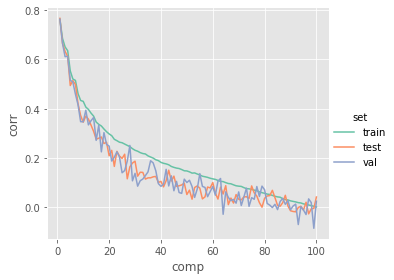

In [24]:
plot_canonical_comps(comps_spec2vec_dcca, latent_dims)

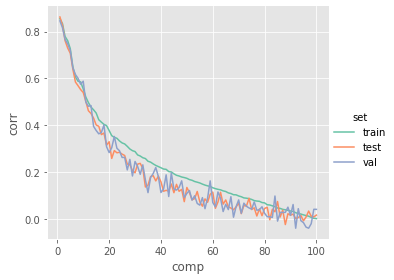

In [25]:
plot_canonical_comps(comps_ms2ds_dcca, latent_dims)

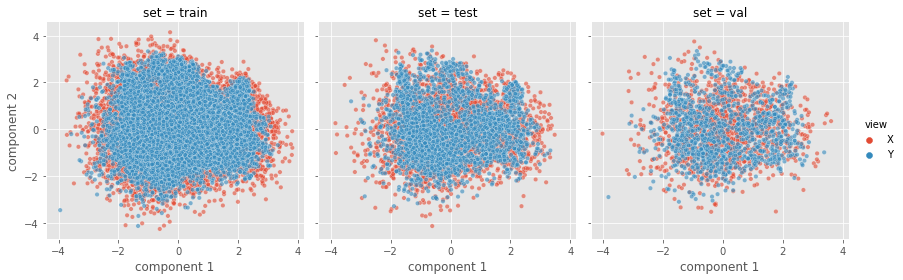

In [26]:
plot_2d_latent(df_spec2vec_dcca)

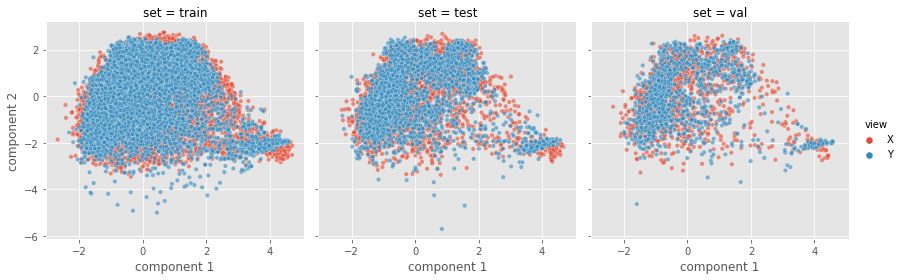

In [27]:
plot_2d_latent(df_ms2ds_dcca)

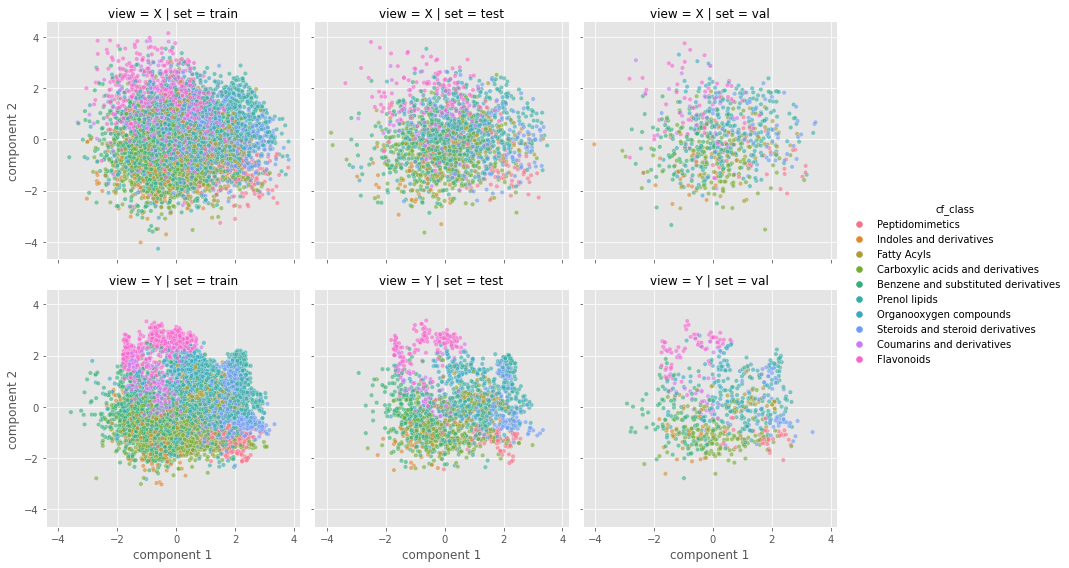

In [30]:
plot_latent_classes(df_spec2vec_dcca)

### 3.2 Save to files

In [28]:
save_pickle(df_spec2vec_dcca, 'dataframe_spec2vec_dcca_%d' % latent_dims, data_path)
save_pickle(df_ms2ds_dcca, 'dataframe_ms2ds_dcca_%d' % latent_dims, data_path)